# DSCI 572 lecture 8

Lecture outline:

- Convnet review (5 min)
- True/False (25 min)
- Using pre-trained networks (5 min)
- Neural networks as feature extractors (5 min)
- Break + teaching evaluations (10 min)
- Some things I should have said earlier (5 min)
- `fit_generator` (5 min)
- More deep learning (10 min, optional)
- Troubleshooting for supervised learning (10 min)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.datasets import mnist

from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Convnet review (5 min)

- Convolutional neural network = convolutional network = convolutional net = convnet = CNN
- Convolutional neural networks are a special case of fully-connected ("regular") neural networks where some of the weights are fixed at 0 and some of the weights are "tied" (fixed to be the same value).
  - It is good to know this, but is actually un-helpful in understanding what they do.
  - The good news is that everything from before (gradients, tricks) carry over nicely.
  - For computational reasons we don't form those giant matrices full of zeros! We just do convolutions. 
- Key insight: things happen "locally" in signals (e.g. images). The top-left matters and the bottom-right matters, but they don't necessarily need to interact right away.
  - so we do some "local processing" on the different parts of the image, and then "report back" and start merging the information when we've reduced the dimension
  - this is the promise/dream of "deep learning": hierarchical abstractions like edges, curves, objects, higher and higher level "understanding"

## True/False on CNNs (25min)

1. In fully-connected networks, we had a **vector** (or 1D array) of activations at each layer (i.e. $x^{(l)}$; a column of circles in our diagram). With 1D convnets, we need a **matrix** (or 2D array) to represent our activations at each layer.
2. The **input** to a `Conv2D` layer is a 2D array.
3. The **output** of a `Conv2D` layer is a 2D array.
4. The **parameters** of a `Conv2D` layer form a 4D array.
5. Imagine we transposed the input to a `Conv1D` layer, making it $d\times T$ instead of $T \times d$. We pass it through the layer, and then transpose the output. Does this give the same result as the original (no transposing)?

<br><br><br><br><br><br><br><br><br>


1. Pooling reduces the number of activations at a given layer. 
2. Pooling introduces new hyperparameters, but not new parameters, into the model.
3. Adding more dense layers (after flattening) always increases the number of parameters of a convnet.
4. Adding more convolutional layers (before flattening) always increases the number of parameters of a convnet.

<br><br><br><br><br><br><br><br><br>

## Using pre-trained networks (5 min)

- In the lab you did transfer learning.
- You can also do something simpler, which is to use the pre-trained model right out of the box.
- tf.keras has a bunch of pre-trained models available, see [here](https://keras.io/applications/).

In [2]:
# from the tf.keras documentation (link above)
model = ResNet50(weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2cb95161c43110f7111970584f804107 so we will re-download the data.
102973440/102967424 [==============================] - 73s 1us/step


Note the important distinction between the choice of architecture (in this case, `ResNet50`) and the choice of dataset (in this case, ImageNet).

In [5]:
# model.summary()

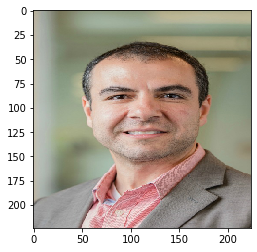

In [6]:
img_path = 'milad.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [7]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04350905', 'suit', 0.22249645), ('n04591157', 'Windsor_tie', 0.2044423), ('n03763968', 'military_uniform', 0.16365887)]


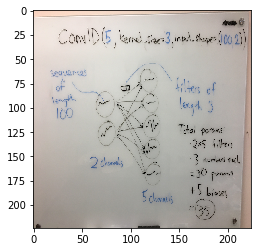

In [8]:
img_path = 'Conv1D.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [9]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n07565083', 'menu', 0.5981505), ('n03291819', 'envelope', 0.14186564), ('n02840245', 'binder', 0.09647612)]


Some ways to use pre-trained networks:

- "Out of the box" with no changes, as above.
  - In the 2017 Capstone project, an MDS student was asked what part was "surprisingly easy". He anwered that a pre-trained model did a good job of sentiment analysis for their task.
- Some changes
  - This is what you do in lab. 
  - You can't use it "out of the box" because the categories are different (dog breeds instead of all sorts of image types).
  - In "Approach 2" you replace the last layer.
  - In "Approach 3" you also "fine tune" some of the pre-trained weights.
    - You initialize SGD with the pre-trained weights.
- Use as a feature extractor
  - You can also drop the last layer and just use it as a feature extractor.
  - What comes next doesn't have to be a neural network!

## Neural network as a feature extrator (5 min)

- This can be done with pre-trained networks or networks you train yourself.
- But it's especially useful with pre-trained networks.
- Here I demonstrate it for a case where I train the model myself.

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255.
X_test = X_test / 255.

# one hot encode outputs
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
cnn = Sequential()
cnn.add(Conv2D(10, (5, 5), input_shape=(28, 28, 1), 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(10, (5, 5), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 10)          2510      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                8050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [16]:
cnn.fit(X_train, Y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.2304 - accuracy: 0.9287
Epoch 2/5
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0735 - accuracy: 0.9771
Epoch 3/5
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0531 - accuracy: 0.9834
Epoch 4/5
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0441 - accuracy: 0.9862
Epoch 5/5
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0369 - accuracy: 0.9883


In [19]:
feature_extractor = Model(cnn.input, cnn.layers[-2].output)

In [20]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 10)          2510      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                8050  

In [21]:
Z_train = feature_extractor.predict(X_train)
Z_test  = feature_extractor.predict(X_test)

In [22]:
Z_train.shape

(60000, 50)

#### Random forest from scratch

- You did this in lab 3 for the smaller digit dataset.
- Need to flatten the images.

#### Put a random forest on top of the feature extractor

In [25]:
rf_ext = RandomForestClassifier(n_estimators=20)
rf.fit(Z_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
rf.score(Z_test, y_test)

0.9882

#### (optional) show that you get the same results with logistic regression

In [17]:
lr = LogisticRegression(multi_class="multinomial", solver="sag", C=1000)
lr.fit(Z_train, y_train)

/Users/mgelbart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
cnn.evaluate(X_train, Y_train)

60000/60000 [==============================] - 15s 245us/step


[0.03379892049527843, 0.9889166666666667]

In [19]:
lr.score(Z_train, y_train)

0.99455

In [29]:
np.argmax(cnn.predict(X_test[:15]), axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1])

In [31]:
lr.predict(Z_test[:15])

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1], dtype=uint8)

- As we can see, the predictions are the same. 
- The probabilities and coefficients aren't exactly the same (it's hard to match everything up perfectly)
- If we want to make them exactly the same, we can set the coefficients:

In [41]:
W = cnn.layers[-1].get_weights()[0]
W.shape

(50, 10)

In [42]:
b = cnn.layers[-1].get_weights()[1]
b.shape

(10,)

In [39]:
lr.coef_.shape

(10, 50)

In [40]:
lr.intercept_.shape

(10,)

In [43]:
lr.coef_ = W.T
lr.intercept_ = b

In [44]:
cnn.predict(X_test[:1])

array([[1.2994968e-08, 1.8788144e-06, 1.1874030e-07, 1.2116589e-05,
        2.8262336e-12, 4.1235131e-07, 2.3576339e-13, 9.9996102e-01,
        5.2370819e-08, 2.4371320e-05]], dtype=float32)

In [46]:
lr.predict_proba(Z_test[:1])

array([[1.29949935e-08, 1.87881642e-06, 1.18740431e-07, 1.21165895e-05,
        2.82624466e-12, 4.12351739e-07, 2.35763422e-13, 9.99961138e-01,
        5.23707229e-08, 2.43713221e-05]], dtype=float32)

Bam!

## Break (10 min)

- We are supposed to set aside time in lecture for you to fill out the UBC teaching evaluations for the course.
- For more info on how these get used, see the bottom section of [this document](https://ubc-mds.github.io/resources_pages/student_feedback/).
- Link to Canvas: https://canvas.ubc.ca/courses/36123

## Some things I should have said earlier (5 min)

- It is good to be aware of the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
    - We did not talk about backpropagation, but in short you apply the chainrule "backwards" through the layers.
    - The repeated application of the chain rule leads to repeated multiplication, often by small numbers when the sigmoid activation is "saturated".
    - The ReLU solves this problem, which is a big part of its popularity.
- We did not cover Dropout beyond what is in the videos you watched.
  - For now, I wanted to say that it's a form of regularization.
  - It does not permanently drop the parameters - just temporarily during training.
  - During prediction, all parameters are used.
  - Dropout is mainly talked about in the context of neural networks, but it can be used elsewhere too!
  - I made a demo with dropout for RBF basis regression.
  - You can take a look - it works similarly to L2 regularization.
- If you want to play around more with neural networks, TensorFlow has a bunch of [built-in datasets](https://www.tensorflow.org/datasets/catalog/overview).
  - Audio, image, video, text (including translation), and more.

## `fit_generator` (5 min)

- What if my dataset doesn't fit into memory on my computer?
- This is a common scenario especially with image or video data.
- Question: do I need my whole dataset all at once?
- Answer: with SGD, you don't!
- Can I load each minibatch from disk into memory, one at a time?
- Yes!
- In tf.keras, we can do this with `fit_generator` instead of `fit`.
  - We covered generators in DSCI 512.
  


In [31]:
def powers_of_two(n):
    return [2**i for i in range(n)]

powers_of_two(5)

[1, 2, 4, 8, 16]

In [36]:
def powers_of_two_generator(n):
    for i in range(n):
        yield 2**i

g = powers_of_two_generator(1000000000000)        

In [60]:
next(g)

8388608

In [38]:
next(g)

2

- We can get each piece of data one at a time, without storing them all in memory at the same time. 
- I wish we have more time to go into this, but we don't, so I at least wanted to mention it.
- **It is quite likely you will need to use this (or something like it) if you're doing deep learning.**
- To use it, you need to create a generator that loads minibatches, and then pass into `fit_generator`.

## (optional) A bunch of random things about deep learing (10 min)

#### Visualizing filters

- This is something people love to do
- Often see something similar to [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) from human visual system
- See AlexNet paper linked below, Figure 3.
- The low layers are often similar in a lot of models
  - Maybe we only need to retrain later layers when transferring to different tasks?

#### Famous architectures

- Historically: Neocognitron, LeNet, HMAX
- More recently:
  - [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) (named after Alex Krizhevsky) set a standard in 2012 (15.4% error vs. 26.2% for closest competitor on [ImageNet](https://en.wikipedia.org/wiki/ImageNet)).
  - [Inception / GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) (pun on Google & LeNet), 2014, 22 layers 
  - [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) (2014)
  - [Generative Adversarial Networks (GANs)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (2014)
  - [ResNet](https://arxiv.org/abs/1512.03385) (2015)
  - [DenseNet](https://arxiv.org/pdf/1608.06993v3.pdf) (2016)
  - [BERT](https://arxiv.org/abs/1810.04805v2) (2018)
  
AlexNet:

- 5 convolutional layers.
- 3 fully-connected layers.
- SGD with momentum.
- ReLU activation functions.
- Data translation/reflection/cropping.
- L2-regularization + dropout.
- 5-6 days on two GPUs

#### Data sets

- There tend to be trendy datasets that evolve over time as the field proceeds. 
- For an example of the focus on a single data set, see this [compilation of MNIST results](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).
- This is good because people can compare with each other.
- But also bad because these data sets may not be important and we may overfit on them (optimization bias as a whole field of researchers).
  - There have been [disturbing findings](http://people.csail.mit.edu/torralba/research/bias/) about the limited transferability of models/insights to new data sets.


#### Preprocessing and initialization

- Preprocessing is how we handle the _data_; initialization refs to our initial guess at the _parameters_ before optimizing. 
- They are also related to each other because the scale of the data affects the scale of the parameters (think of linear regression).

Preprocessing (about $X$ and $y$)

- Standardization/normalization is a good idea for deep learning.
- Some methods are not independent across features: e.g. PCA for preprocessing, other methods like [whitening](http://deeplearning.stanford.edu/wiki/index.php/Whitening).

Initialization (about $W$)

- Sigmoids units are sensitive to initialization, ReLU less so.
- Overall initialization matters _a lot_.
- Cannot just initialize to zero because then gradient will be zero. Other pathologies too, like cannot initialize all weights to the same value.
- Keras offers [a bunch of initialization options](https://keras.io/initializations/), you may need to experiment a bit. You can view it as just another hyperparameter.
  - Speaking of which...

#### Hyperparameter optimization

- We are left with a lot of hyperparameters. Hyperparameter optimization now becomes important. 
- One important choice is the number of size/layers. Some prefer "wide" and others prefer "deep" nets. 
- A specification of these is called the network _architecture_ and searching for the best one is sometimes called **architecture search**.
- Currently, we don't go into this much in MDS (just whatever is in DSCI 573). 
- However, I can recommend two useful tools:
  - Random search, as in scikit-learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - Something smarter, which could be Bayesian optimization. I recommend [`scikit-optimize`](https://scikit-optimize.github.io/). (Note: not to be confused with `scipy.optimize`!)
  

#### Autoencoders

- Unsupervised learning by minimizing _reconstruction loss_.
- We've usually associated loss functions with supervised learning, but actually several unsupervised methods like PCA and $k$-means clustering can be thought of us minimizing the reconstruction error.
  - See optional question in 563 lab about PCA as a special case of a neural network (autoencoder).
- Autoencoders are neural nets that try to reconstruct the input examples.
- Squeeze the information through an "information bottleneck".
- Autoencoders automatically learn _compressed_ representations.
- Strong connection between compression and unsupervised learning (especially the lossy part of compression).

#### Types of neural networks

- Fully-connected (`Dense` in Keras)
- Convolutional  (e.g. `Conv2D` in Keras)
- Recurrent (including LSTM, e.g. `LSTM` in Keras)
  - This is as opposed to feedforward (`Sequential` in Keras)
  - Coming in DSCI 575.
- Recursive (apparently a more general case of recurrent, acronym "RNN" usually refers to recurrent)
- Others...

#### GPUs and parallel processing

- Breakdown of [Moore's law](https://en.wikipedia.org/wiki/Moore%27s_law).
- NVIDIA is the market leader in making GPUs. 
- What parts are parallelizable?
  - Matrix multiplication.
  - Per-example gradients in an SGD minibatch (e.g. if `batch_size=128`, can be parallelized over 128 threads).
  - Some parts need to be iterative, like the high-level GD/SGD steps.

#### AI safety and adversarial examples

- See this [OpenAI blog post](https://blog.openai.com/adversarial-example-research/) or some work on [adversarial stickers](https://arxiv.org/pdf/1904.00759.pdf).
- If the input is a $1000\times 1000$ image, the input space is so big.
  - it is hard to imagine all the possible perturbations, so some of them work out.
- Maybe more of this coming in DSCI 541.

#### What else didn't we cover in this course?

- A ton of stuff, of course, including...
  - Reinforcement learning (e.g. AlphaGo)
  - RNNs (DSCI 575)
  - at-scale considerations, distributed computing (beyond DSCI 525)
  - interpretability of deep learning [(recent article)](https://distill.pub/2018/building-blocks/)
  - Bayesian neural nets
  - [GANs](https://en.wikipedia.org/wiki/Generative_adversarial_network)
  - Backpropagation
  - much much more...
  
For more information, see the various resources on the course README.

## Troubleshooting for supervised learning (10 min)

- My model doesn't work, what do I do next?
- First thing I would do is look at the training error and validation error.
  - Training error is high: am I underfitting?
  - Big gap between train/test: am I overfitting? 
  - New thing to worry about if training error is high: is my optimization working?

Below is a list of problems you might encounter:

#### Fundamental learning issues:

- Did I overfit? 
- Did I underfit?
- Did I reach the "irreducible error"?
- Do I need more data? Try training on more or less data and see what happens.
- Do I need better data?
- Did I overfit on the validation set?
- Do I need to select methods more appropriate to my data type (time series, sequences, images, graphs, etc)?

#### Data preparation issues

- Do I have data quality problems?
- Did I preprocess my data in a sensible way?
- What about missing data?
- Are my features reasonable?

#### Loss function issues:

- Does my loss function capture my idea of a "good" model? 

#### Speed issues:

- Is my training procedure too slow to be useful?
- Is my prediction/inference procedure too slow to be useful?
- Is my entire pipeline too slow to support rapid prototyping?

#### Optimization issues:

- Did my optimization not converge? Try plotting training error vs. iterations.
- Was it an initialization problem?
- Did I reach a local minimum? Saddle point?


### That's all, folks!

- This is my last lecture in the program. 
  - I'll be lab instructor for DSCI 553 next block.
  - I'll be involved with Capstone.